In [1]:
# cleaned up and generalized version of "5_identify_regions_activation.ipynb"
# for each task + main condition, looks at main ROIs suggested by neurosynth 
# and how within and between subj spatial correlations change across encounters

# also saves these correlations into a json of task:contrast and then {brain_roi: [list of area names]} and {corrs: [corresponding list of correlations]} 
# (for fixed the corr is between subjects and for indiv its within subjects)
# save one for the fixed and one for the individual contrasts in the correlation_analysis_results folder

# imports and general helper functions

In [2]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import pickle
import seaborn as sns
import gc
import psutil
import math
import scipy.stats as stats
from matplotlib.patches import Patch
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict
from nilearn.maskers import NiftiLabelsMasker


In [3]:
# general helper functions:
def build_contrast_map_path(base_dir, level, subject, session, task, contrast_name):
    """Build the file path for a contrast map."""
    filename = f'{subject}_{session}_task-{task}_contrast-{contrast_name}_rtmodel-rt_centered_stat-effect-size.nii.gz'
    
    # NOTE: as of 7/6/25 for sub 10 in flanker the format is different: sub-s10_ses-01_run-1_task-flanker_contrast-incongruent-congruent_rtmodel-rt_centered_stat-effect-size.nii.gz
    if (subject == 'sub-s10' and task == 'flanker'):
        filename = f'{subject}_{session}_run-1_task-{task}_contrast-{contrast_name}_rtmodel-rt_centered_stat-effect-size.nii.gz'
        
    return os.path.join(base_dir, level, subject, task, 'indiv_contrasts', filename)

def is_valid_contrast_map(img_path):
    """Check if a contrast map has sufficient variance and no NaN values."""
    try:
        img = nib.load(img_path)
        data = img.get_fdata()
        return np.std(data) > 1e-10 and not np.isnan(data).any()
    except Exception as e:
        print(f"Error validating {img_path}: {e}")
        return False
        
def clean_z_map_data(z_map, task, contrast_name, encounter):
    """Clean z-map data by handling NaN and infinity values."""
    data = z_map.get_fdata()
    if np.isnan(data).any() or np.isinf(data).any():
        data = np.nan_to_num(data)
        z_map = nib.Nifti1Image(data, z_map.affine, z_map.header)
        print(f"Warning: Fixed NaN/Inf values in {task}:{contrast_name}:encounter-{encounter+1}")
    return z_map

def cleanup_memory():
    """
    Clean up memory between batches
    """
    # Force garbage collection
    gc.collect()
    
    # Get memory info
    memory = psutil.virtual_memory()
    print(f"Memory after cleanup: {memory.percent:.1f}% used ({memory.available/(1024**3):.1f}GB available)")
def convert_to_regular_dict(d):
    if isinstance(d, defaultdict):
        return {k: convert_to_regular_dict(v) for k, v in d.items()}
    elif isinstance(d, list):
        return [convert_to_regular_dict(i) for i in d]
    else:
        return d

# constants, filenames, and roi labels

In [11]:
# all tasks and contrasts
TASKS = ["nBack","flanker","directedForgetting","goNogo", "shapeMatching", "stopSignal", "cuedTS", "spatialTS"]
CONTRASTS = {}
CONTRASTS["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"] # the nback contrasts
CONTRASTS["flanker"] = ["incongruent-congruent", "task-baseline"]
CONTRASTS["directedForgetting"] = ["neg-con", "task-baseline","response_time"]
CONTRASTS["goNogo"] = ["nogo_success-go", "nogo_success","task-baseline","response_time"] # go_rtModel check
CONTRASTS["shapeMatching"] = ["DDD", "DDS", "DNN", "DSD", "main_vars", "SDD", "SNN", "SSS", "task-baseline","response_time"]
CONTRASTS["stopSignal"] = ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
CONTRASTS["cuedTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]
CONTRASTS["spatialTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]

# main conditions and contrasts that we're interested in looking at
requested_task_contrasts = defaultdict(lambda: defaultdict(list))
requested_task_contrasts['nBack'] = ["twoBack-oneBack", 'task-baseline']
requested_task_contrasts['flanker'] = ["incongruent-congruent",'task-baseline']
requested_task_contrasts['directedForgetting'] = ["neg-con",'task-baseline']
requested_task_contrasts['goNogo'] = ["nogo_success-go",'task-baseline']
requested_task_contrasts['shapeMatching'] = ["main_vars",'task-baseline']
requested_task_contrasts['stopSignal'] = ["stop_failure-go",'task-baseline']
requested_task_contrasts['cuedTS'] = ["task_switch_cost",'task-baseline']
requested_task_contrasts['spatialTS'] = ["task_switch_cost",'task-baseline']

compiled_req_contrasts = ["twoBack-oneBack", 'task-baseline', "incongruent-congruent", "neg-con", "nogo_success-go", "main_vars", "stop_failure-go","task_switch_cost"]

encounters = ['01', '02','03','04','05']

# load subject files per session

In [5]:
# load files per subject per session

# where the first level contrast maps are stored
BASE_DIR = '/oak/stanford/groups/russpold/data/network_grant/discovery_BIDS_20250402/derivatives/'
LEVEL = 'output_lev1_mni'
# subjects in the discovery sample
SUBJECTS = ['sub-s03', 'sub-s10', 'sub-s19', 'sub-s29', 'sub-s43']
SESSIONS = ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09','ses-10']

# number of encounters each subject has with a task
max_num_encounters = 5

In [6]:
# arrange each subjects maps by which encounter num it is
all_contrast_maps = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
encounter_maps = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for task in TASKS:
    for contrast_name in CONTRASTS[task]:
        for subject in SUBJECTS:
            overall_encounter_count = 0
            
            for session in SESSIONS:
                contrast_map_path = build_contrast_map_path(BASE_DIR, LEVEL, subject, session, task, contrast_name)
                
                if os.path.exists(contrast_map_path):
                    all_contrast_maps[task][contrast_name][subject].append(contrast_map_path)
                    encounter_maps[task][contrast_name][subject][overall_encounter_count] = contrast_map_path
                    overall_encounter_count += 1

first_level_session_maps = all_contrast_maps
first_level_encounter_maps = encounter_maps

# general loading and plotting functions that can apply across all tasks

In [7]:
# relevant loading functions taken from 3_create_RSMs_first_level
# function to gather maps of a certain task/contrast from first_level_encounter_maps
def gather_tc_maps(req_tasks,req_contrasts,all_maps=first_level_encounter_maps,req_encounters=[0,1,2,3,4], req_subjects = SUBJECTS):
    '''
    Get a list of loaded niftis for specific task/contrast/encounter combinations of first level maps 
    
    Parameters
        req_tasks: list of tasks as strings (all tasks have to be from the TASKS dict)
        req_contrasts: list of contrasts as strings (all tasks have to be from the CONTRASTS dict)
        all_maps: [task][contrast_name][subject][overall_encounter_count] -> one map each (here it is in a filepath format)
        req_encounters: list of encounter numbers that are requested (default is all 5)
        req_subjects: list of subject id strings that are requested (default is all in SUBJECTS)
    Return
        specified_maps: list of loaded nifti files that fit the requested task, contrast, and encounter (this returns this for all subjects)
        specified_descriptors: list of descriptions of each file (i.e. titles)
        data_title: informative title for the RSM that will later be created
    
    '''
    specified_maps = []
    specified_descriptors = []
    max_num_encounters = 5

    if (len(req_tasks) == 0) or (len(req_contrasts) == 0):
        return [], [], ''

    for task in req_tasks:
        if task not in TASKS:
            print(f"task {task} not in task masterlist")
            continue
    
        for contrast in req_contrasts:
            if contrast not in CONTRASTS[task]: # make sure this contrast exists in the given task
                print(f"skipped for contrast {contrast} and task {task}")
                continue
                
            for subject in req_subjects:
                if subject not in SUBJECTS:
                    print(f"subject: {subject} is not in this dataset, so skipped")
                    continue
                    
                for encounter in req_encounters:
                    if encounter < 0 or encounter >= max_num_encounters:
                        continue

                    descriptor_name = f"{subject}:encounter-0{encounter + 1}"
                            
                    if task in all_maps.keys():
                        if contrast in all_maps[task].keys():
                            if subject in all_maps[task][contrast].keys():
                                if encounter in all_maps[task][contrast][subject].keys():

                                    map_data = all_maps[task][contrast][subject][encounter]
                                    
                                    # Check if file is already loaded
                                    if isinstance(map_data, str):
                                        # map_data is a file path, need to load it
                                        try:
                                            if os.path.exists(map_data):
                                                loaded_map = nib.load(map_data)
                                                specified_maps.append(loaded_map)
                                                specified_descriptors.append(descriptor_name)
                                            else:
                                                print(f"File not found: {map_data}")
                                                failed_loads.append((descriptor_name, "File not found"))
                                        except Exception as e:
                                            print(f"Error loading {map_data}: {str(e)}")
                                    else:
                                        print(f"Unexpected data type for {descriptor_name}: {type(map_data)}")
                                        
                                else:
                                    print(f"{task}|{contrast}|{subject}: {encounter}")
                                    continue
                            else:
                                print(f"{task}|{contrast} subject {subject}")
                                continue
                        else:
                            print(f"{task}:{contrast}")
                            continue
                    else:
                        print(f"{task}")
                        continue
    # create RSM title
    data_title = ''
    if (len(req_tasks) == 1):
        data_title += f'Task:{req_tasks[0]}|'
    else:  # more than 1 task
        data_title += 'Task:'
        for i, task in enumerate(req_tasks):
            if (i != len(req_tasks) - 1):
                data_title += f"{task},"
            else:
                data_title += f"{task}"
        data_title += '|'

    if (len(req_contrasts) == 1):
        data_title += f'Contrast:{req_contrasts[0]}'
    else:
        data_title += 'Contrast:'
        for i, contrast in enumerate(req_contrasts):
            if (i != (len(req_contrasts) - 1)):
                data_title += f"{contrast},"
            else:
                data_title += f"{contrast}"
    
    return specified_maps, specified_descriptors, data_title

In [8]:
# sort this by encounter (later move this into the main gather_tc-maps func)
def reorganize_dict(original_dict):
    new_dict = {}
    
    for task, contrasts in original_dict.items():
        new_dict[task] = {}
        
        for contrast, data in contrasts.items():
            new_dict[task][contrast] = {}
            
            maps_list = data['maps_list']
            descriptors_list = data['descriptors_list']
            
            # Process each map and its corresponding descriptor
            for map_obj, descriptor in zip(maps_list, descriptors_list):
                # (e.g., 'sub-s10:encounter-01')
                parts = descriptor.split(':')
                sub = parts[0]  # 'sub-s10'
                encounter = parts[1]  # 'encounter-01'
                encounter_num = encounter.split('-')[1]  # '01'
                
                # Create nested structure if it doesn't exist
                if sub not in new_dict[task][contrast]:
                    new_dict[task][contrast][sub] = {}
                
                # Assign the map object to the appropriate location
                new_dict[task][contrast][sub][encounter_num] = map_obj
    
    return new_dict
    
def gather_tc_maps_full_task(req_tasks_contrasts = requested_task_contrasts, curr_task = None, req_contrasts = None, create_subset=False):
    '''
    Get a dict of loaded niftis for every contrast of a requested task (uses gather_tc_maps and puts it into a dict organized
    by task/contrast). If curr_task or req_contrasts is not None, then just do this for one task (not all task/contrasts in 
    req_tasks_contrasts)
    
    Parameters
        req_tasks_contrasts = dict of all tasks that we are organizing
        curr_task: specific task to load (if create_subset = True) instead of doing it for all task/contrasts
        req_contrasts: specific contrasts to load (if create_subset=True and curr_task != None). 
        create_subset: default False (if true, then don't organize the dict for all task/contrasts, but only for the requested current task and its contrasts).
    Return
        task_contrast_all_maps[task][contrast] = ["maps_list","descriptors_list", "data_title"]
    '''
    task_contrast_all_maps = {}

    # if it was just a subset
    if ((create_subset) and (curr_task != None)):
        if req_contrasts == None:
            req_contrasts = req_tasks_contrasts[curr_task]

        print(f"creating a subset dict for {curr_task} and contrasts {req_contrasts.items()}")

        print("MISSING:")
        task_contrast_all_maps[curr_task] = {}
        for contrast in req_contrasts:
            task_contrast_all_maps[curr_task][contrast] = {}
            task_contrast_all_maps[curr_task][contrast]["maps_list"] = []
            task_contrast_all_maps[curr_task][contrast]["descriptors_list"] = []
            task_contrast_all_maps[curr_task][contrast]["data_title"] = ""
        
            req_tasks_tc = [curr_task]
            req_contrasts_tc = [contrast]
        
            task_contrast_all_maps[curr_task][contrast]["maps_list"],task_contrast_all_maps[curr_task][contrast]["descriptors_list"],task_contrast_all_maps[curr_task][contrast]["data_title"] = gather_tc_maps(req_tasks_tc,req_contrasts_tc,all_maps=first_level_encounter_maps,req_encounters=[0,1,2,3,4], req_subjects = SUBJECTS)

        return task_contrast_all_maps

    # if it was for loading all of the task/contrast combos
    for curr_task in req_tasks_contrasts:
        task_contrast_all_maps[curr_task] = {}

        print(f"MISSING for {curr_task}:")
        for contrast in req_tasks_contrasts[curr_task]:
            task_contrast_all_maps[curr_task][contrast] = {}
            task_contrast_all_maps[curr_task][contrast]["maps_list"] = []
            task_contrast_all_maps[curr_task][contrast]["descriptors_list"] = []
            task_contrast_all_maps[curr_task][contrast]["data_title"] = ""
        
            req_tasks_tc = [curr_task]
            req_contrasts_tc = [contrast]
        
            task_contrast_all_maps[curr_task][contrast]["maps_list"],task_contrast_all_maps[curr_task][contrast]["descriptors_list"],task_contrast_all_maps[curr_task][contrast]["data_title"] = gather_tc_maps(req_tasks_tc,req_contrasts_tc,all_maps=first_level_encounter_maps,req_encounters=[0,1,2,3,4], req_subjects = SUBJECTS)
            
    return task_contrast_all_maps

In [9]:
def standardize_mask(mask_img, dtype=bool):
    """Ensure mask has consistent data type and format"""
    mask_data = mask_img.get_fdata()
    # Convert to binary and specified dtype
    binary_data = (mask_data > 0).astype(dtype)
    return image.new_img_like(mask_img, binary_data)

# parcellate across encounters (for now s03 is missing)

In [11]:
# load all of the maps in an organized dict and see which maps are missing per task
task_contrast_all_maps = gather_tc_maps_full_task(req_tasks_contrasts = requested_task_contrasts,create_subset=False)

# Use the function
task_contrast_enc_all_maps = reorganize_dict(task_contrast_all_maps)

MISSING for nBack:
nBack|twoBack-oneBack subject sub-s03
nBack|twoBack-oneBack subject sub-s03
nBack|twoBack-oneBack subject sub-s03
nBack|twoBack-oneBack subject sub-s03
nBack|twoBack-oneBack subject sub-s03
nBack|task-baseline subject sub-s03
nBack|task-baseline subject sub-s03
nBack|task-baseline subject sub-s03
nBack|task-baseline subject sub-s03
nBack|task-baseline subject sub-s03
MISSING for flanker:
flanker|incongruent-congruent subject sub-s03
flanker|incongruent-congruent subject sub-s03
flanker|incongruent-congruent subject sub-s03
flanker|incongruent-congruent subject sub-s03
flanker|incongruent-congruent subject sub-s03
flanker|task-baseline subject sub-s03
flanker|task-baseline subject sub-s03
flanker|task-baseline subject sub-s03
flanker|task-baseline subject sub-s03
flanker|task-baseline subject sub-s03
MISSING for directedForgetting:
directedForgetting|neg-con subject sub-s03
directedForgetting|neg-con subject sub-s03
directedForgetting|neg-con subject sub-s03
directedF

# For all subjects, parcellate each session and save the DF

In [12]:
# 1. Load the Schaefer 400 atlas
print("Loading Schaefer 400 atlas...")
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(
    n_rois=400, 
    yeo_networks=7,  # 7 or 17 networks available
    resolution_mm=2  # 1mm or 2mm resolution
)
print(f"Atlas loaded with {len(schaefer_atlas.labels)} regions")
print(f"Atlas shape: {nib.load(schaefer_atlas.maps).shape}")

Loading Schaefer 400 atlas...


[get_dataset_dir] Dataset found in /home/users/nklevak/nilearn_data/schaefer_2018

Atlas loaded with 400 regions
Atlas shape: (91, 109, 91)


In [19]:
encounters = ['01', '02','03','04','05']
parcel_dict = {}
# parcel_dict = {curr_subj: {curr_task: {curr_contrast: {}}}}

for curr_subj in SUBJECTS:
    # for now skip s03
    if (curr_subj == "sub-s03"):
        continue
        
    parcel_dict[curr_subj] = {}
    
    for curr_task in requested_task_contrasts:
        parcel_dict[curr_subj][curr_task] = {}

        for curr_contrast in requested_task_contrasts[curr_task]:
            parcel_dict[curr_subj][curr_task][curr_contrast] = {}

            for enc in encounters:
                print(f"{curr_task}{curr_contrast}{curr_subj}")

                try:
                    fmri_img = task_contrast_enc_all_maps[curr_task][curr_contrast][curr_subj][enc]
                    print(f"fMRI data loaded successfully for {curr_subj} {curr_task} {curr_contrast} encounter {enc}")
                    print(f"fMRI shape: {fmri_img.shape}")
    
                    # make the masker and get regional avg activation
                    masker = NiftiLabelsMasker(
                        labels_img=schaefer_atlas.maps,
                        standardize=False, 
                        memory='nilearn_cache',
                        strategy='mean'  # Average activation within each region
                    )
                    # Extract regional values
                    regional_values = masker.fit_transform(fmri_img)
                    # Create a more meaningful output
                    region_labels = [label.decode('utf-8') if isinstance(label, bytes) else label 
                                    for label in schaefer_atlas.labels]
                    activation_df = pd.DataFrame({
                        'region': region_labels,
                        'activation': regional_values.flatten(),
                        'network': [label.split('_')[1] if '7Networks' in label else 'Unknown' 
                                   for label in region_labels]
                    })
                
                    # save the activation df
                    parcel_dict[curr_subj][curr_task][curr_contrast][enc] = activation_df
                    
                except KeyError as e:
                    print(f"Warning: Data not found for {curr_subj} {curr_task} {curr_contrast} encounter {enc}")
                    print(f"Missing key: {e}")
                    continue

nBacktwoBack-oneBacksub-s10
fMRI data loaded successfully for sub-s10 nBack twoBack-oneBack encounter 01
fMRI shape: (97, 115, 97)
nBacktwoBack-oneBacksub-s10
fMRI data loaded successfully for sub-s10 nBack twoBack-oneBack encounter 02
fMRI shape: (97, 115, 97)
nBacktwoBack-oneBacksub-s10
fMRI data loaded successfully for sub-s10 nBack twoBack-oneBack encounter 03
fMRI shape: (97, 115, 97)
nBacktwoBack-oneBacksub-s10
fMRI data loaded successfully for sub-s10 nBack twoBack-oneBack encounter 04
fMRI shape: (97, 115, 97)
nBacktwoBack-oneBacksub-s10
fMRI data loaded successfully for sub-s10 nBack twoBack-oneBack encounter 05
fMRI shape: (97, 115, 97)
nBacktask-baselinesub-s10
fMRI data loaded successfully for sub-s10 nBack task-baseline encounter 01
fMRI shape: (97, 115, 97)
nBacktask-baselinesub-s10
fMRI data loaded successfully for sub-s10 nBack task-baseline encounter 02
fMRI shape: (97, 115, 97)
nBacktask-baselinesub-s10
fMRI data loaded successfully for sub-s10 nBack task-baseline enc

In [20]:
# save this to a pickled file
with open('schafer400_dfs/discovery_parcel_mean_924.pkl', 'wb') as f:
    pickle.dump(parcel_dict, f)

# load the DF and run analyses per subject

In [10]:
with open('schafer400_dfs/discovery_parcel_mean_924.pkl', 'rb') as f:
    loaded_parcel_dict = pickle.load(f)

In [14]:
def analyze_parcel_practice_effects(parcel_dict, subject, task, contrast):
    """
    Detailed analysis of practice effects for individual parcels
    """
    
    # Get all individual parcels
    first_encounter = parcel_dict[subject][task][contrast]['01']
    all_parcels = first_encounter['region'].tolist()
    
    parcel_results = {}
    
    for parcel in all_parcels:
        # Extract trajectory for this specific parcel
        trajectory = []
        encounters = [1, 2, 3, 4, 5]
        
        for enc_num, enc in enumerate(['01', '02', '03', '04', '05'], 1):
            df = parcel_dict[subject][task][contrast][enc]
            activation = df[df['region'] == parcel]['activation'].iloc[0]
            trajectory.append(activation)
        
        trajectory = np.array(trajectory)
        
        # Statistical analysis
        slope, intercept, r_value, p_value, std_err = stats.linregress(encounters, trajectory)
        
        # Calculate additional metrics
        initial_activation = trajectory[0]
        final_activation = trajectory[-1]
        max_activation = np.max(trajectory)
        min_activation = np.min(trajectory)
        
        # Effect size calculations
        if abs(initial_activation) > 0.001:
            percent_change = ((final_activation - initial_activation) / abs(initial_activation)) * 100
        else:
            percent_change = 0
        
        # Cohen's d for effect size
        trajectory_std = np.std(trajectory)
        if trajectory_std > 0:
            cohens_d = abs(final_activation - initial_activation) / trajectory_std
        else:
            cohens_d = 0
        
        # Classification
        significant_practice = (slope < 0) and (p_value < 0.05)
        strong_practice = significant_practice and (abs(percent_change) > 10)
        
        parcel_results[parcel] = {
            'trajectory': trajectory,
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_value**2,
            'p_value': p_value,
            'std_error': std_err,
            'initial_activation': initial_activation,
            'final_activation': final_activation,
            'percent_change': percent_change,
            'cohens_d': cohens_d,
            'max_activation': max_activation,
            'min_activation': min_activation,
            'activation_range': max_activation - min_activation,
            'significant_practice': significant_practice,
            'strong_practice': strong_practice,
            'network': df[df['region'] == parcel]['network'].iloc[0]
        }
    
    return parcel_results

In [42]:
def create_parcel_practice_heatmap(parcel_results):
    """
    Create a heatmap showing practice effects across all parcels
    """
    
    # Prepare data for heatmap
    df = pd.DataFrame(parcel_results).T
    
    # Sort by network and then by slope
    df_sorted = df.sort_values(['network', 'slope'])
    
    # Create trajectory matrix
    trajectory_matrix = np.array([row['trajectory'] for _, row in df_sorted.iterrows()])
    
    # Create the heatmap
    plt.figure(figsize=(30, 12))
    
    # Plot trajectories
    sns.heatmap(trajectory_matrix, 
                xticklabels=['Enc 1', 'Enc 2', 'Enc 3', 'Enc 4', 'Enc 5'],
                yticklabels=[row.name.split('_')[-1] for _, row in df_sorted.iterrows()],
                cmap='RdBu_r', center=0, 
                cbar_kws={'label': 'Activation'})
    
    plt.title('Practice Effects Across All Parcels')
    plt.xlabel('Encounter')
    plt.ylabel('Brain Parcels (sorted by network)')
    
    # Add network boundaries
    networks = df_sorted['network'].values
    boundaries = []
    current_network = networks[0]
    
    for i, network in enumerate(networks[1:], 1):
        if network != current_network:
            boundaries.append(i)
            current_network = network
    
    for boundary in boundaries:
        plt.axhline(y=boundary, color='white', linewidth=2)
    
    plt.tight_layout()
    plt.show()

In [48]:
def plot_slope_hist(main_dict):
    # Extract slopes from  data dictionary
    slopes = []
    for parcel_name, parcel_info in main_dict.items():
        slopes.append(parcel_info['slope'])
    
    # Convert to numpy array for easier handling
    slopes = np.array(slopes)
    
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(slopes, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
    plt.xlabel('Slope (change per encounter)')
    plt.ylabel('Number of parcels')
    plt.title('Distribution of Practice Effects Across Brain Parcels')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add some summary stats as text
    plt.text(0.02, 0.95, f'Mean slope: {np.mean(slopes):.4f}\n'
                         f'Median slope: {np.median(slopes):.4f}\n'
                         f'Negative slopes: {np.sum(slopes < 0)} ({np.sum(slopes < 0)/len(slopes)*100:.1f}%)',
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print some quick stats
    print(f"Total parcels: {len(slopes)}")
    print(f"Negative slopes (practice): {np.sum(slopes < 0)} ({np.sum(slopes < 0)/len(slopes)*100:.1f}%)")
    print(f"Positive slopes (fatigue): {np.sum(slopes > 0)} ({np.sum(slopes > 0)/len(slopes)*100:.1f}%)")
    print(f"Mean slope: {np.mean(slopes):.6f}")

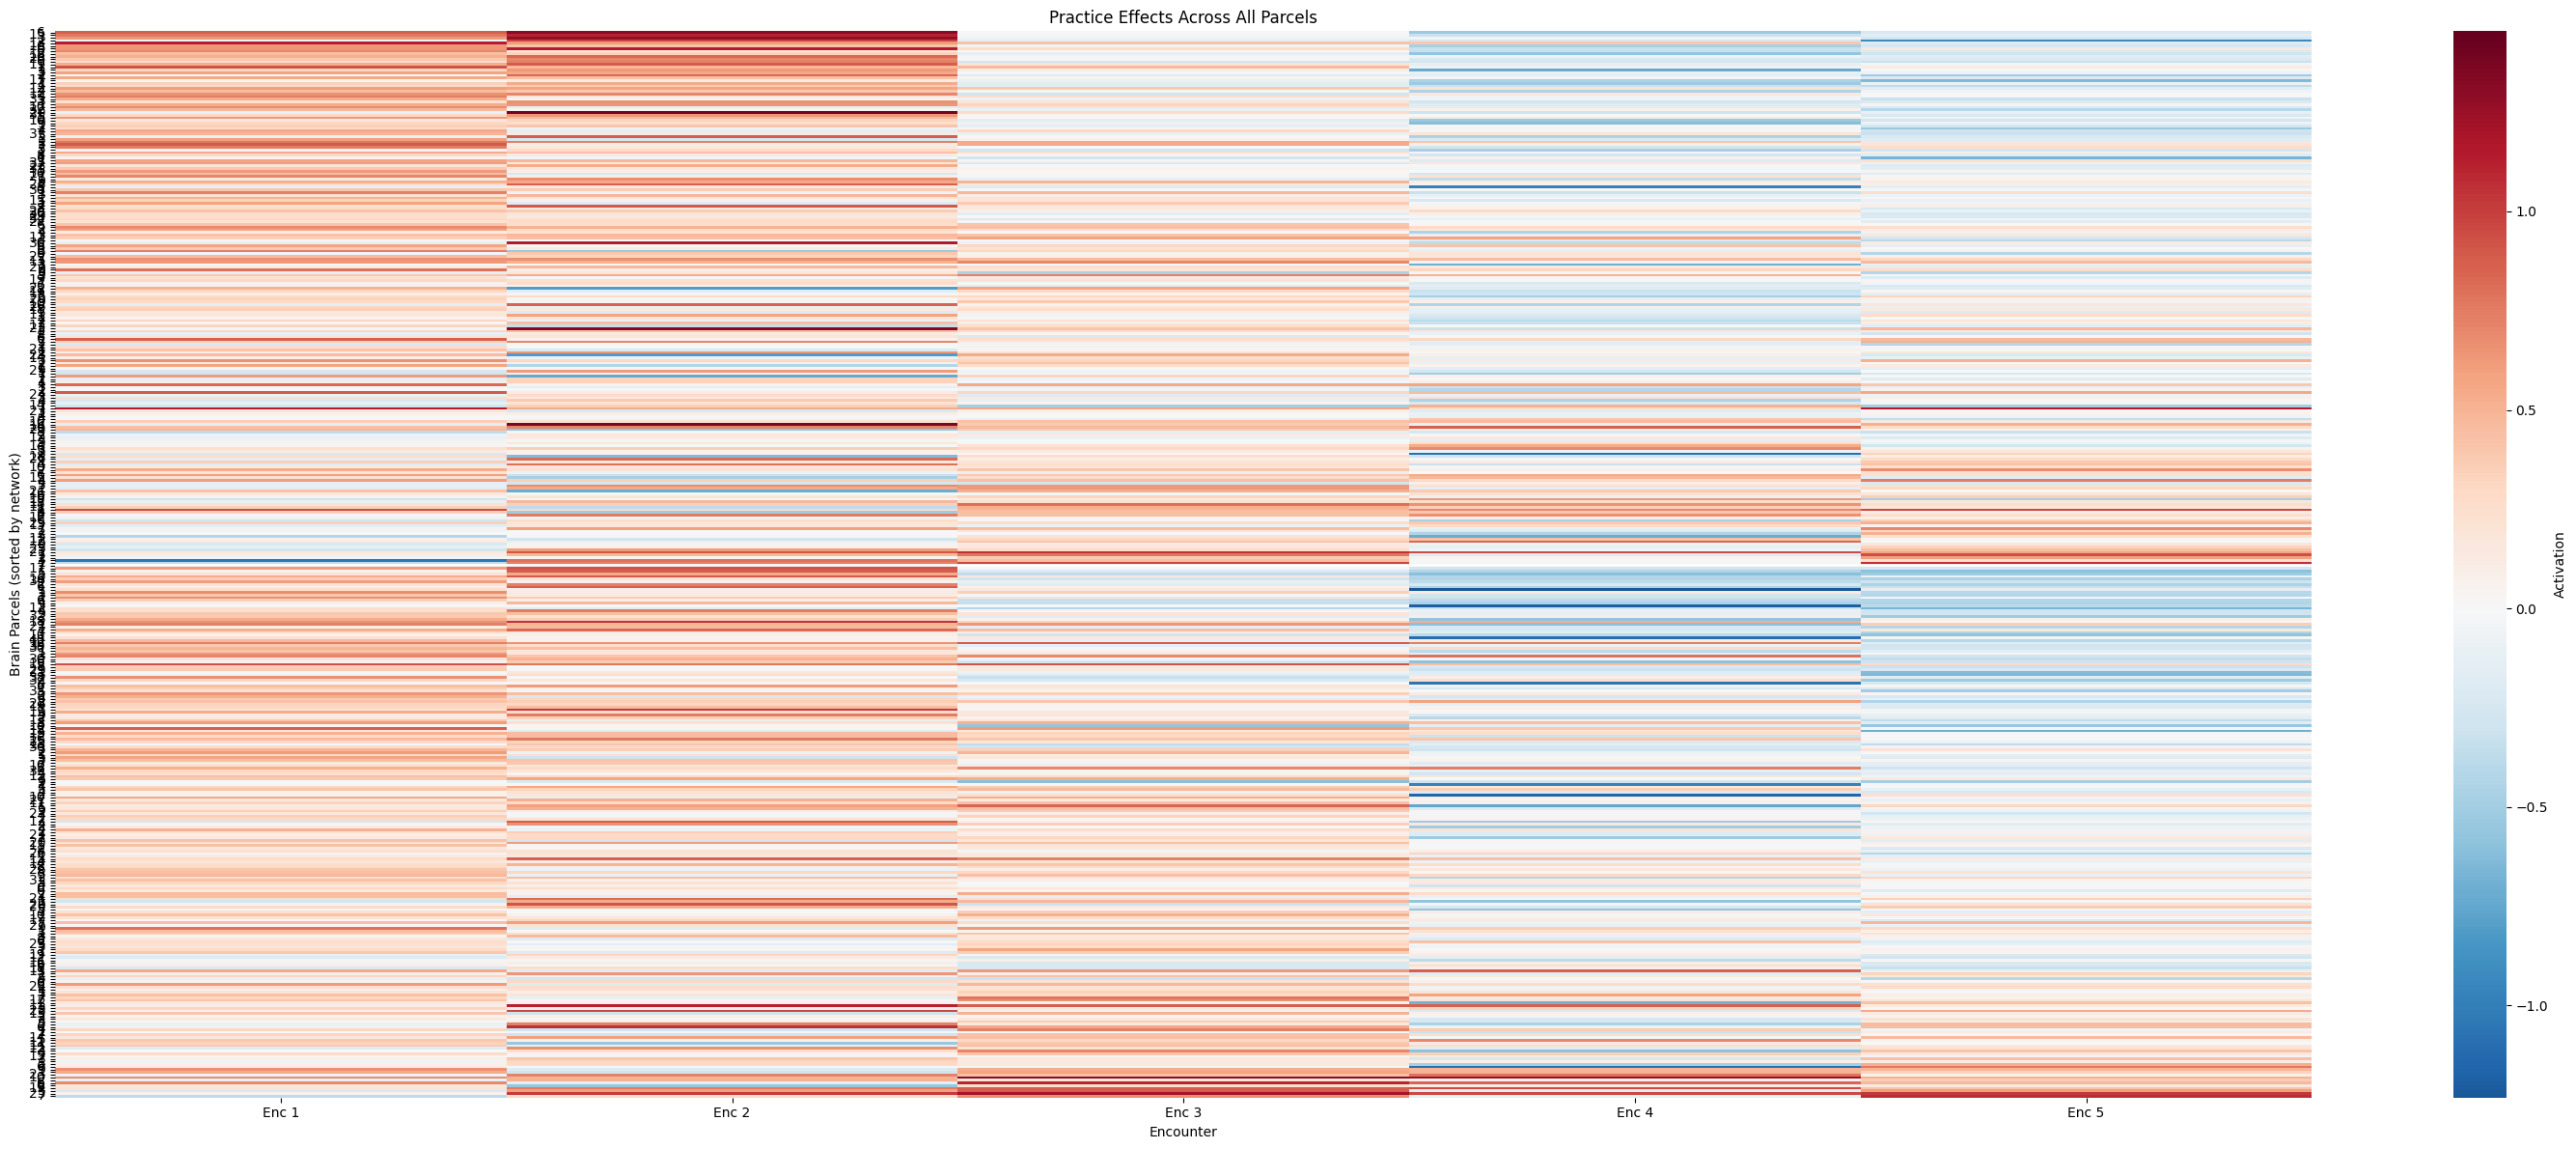

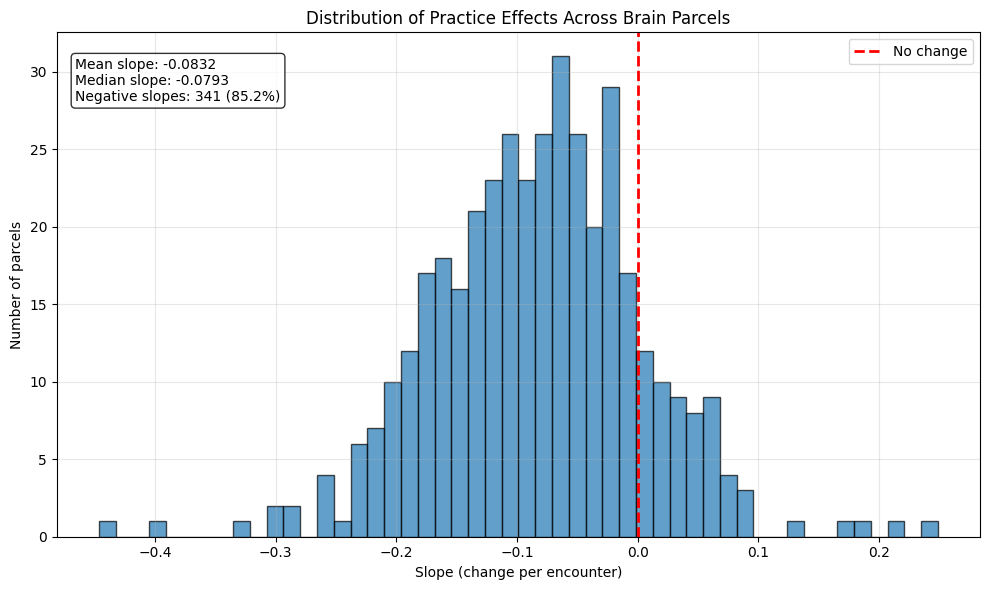

Total parcels: 400
Negative slopes (practice): 341 (85.2%)
Positive slopes (fatigue): 59 (14.8%)
Mean slope: -0.083228


In [51]:
# Run the analysis
subject = 'sub-s19'
task = 'nBack'
contrast = 'twoBack-oneBack'

# 1. Analyze all parcels
parcel_results = analyze_parcel_practice_effects(loaded_parcel_dict, subject, task, contrast)

# 2. Create visualizations
create_parcel_practice_heatmap(parcel_results)
plot_slope_hist(parcel_results)

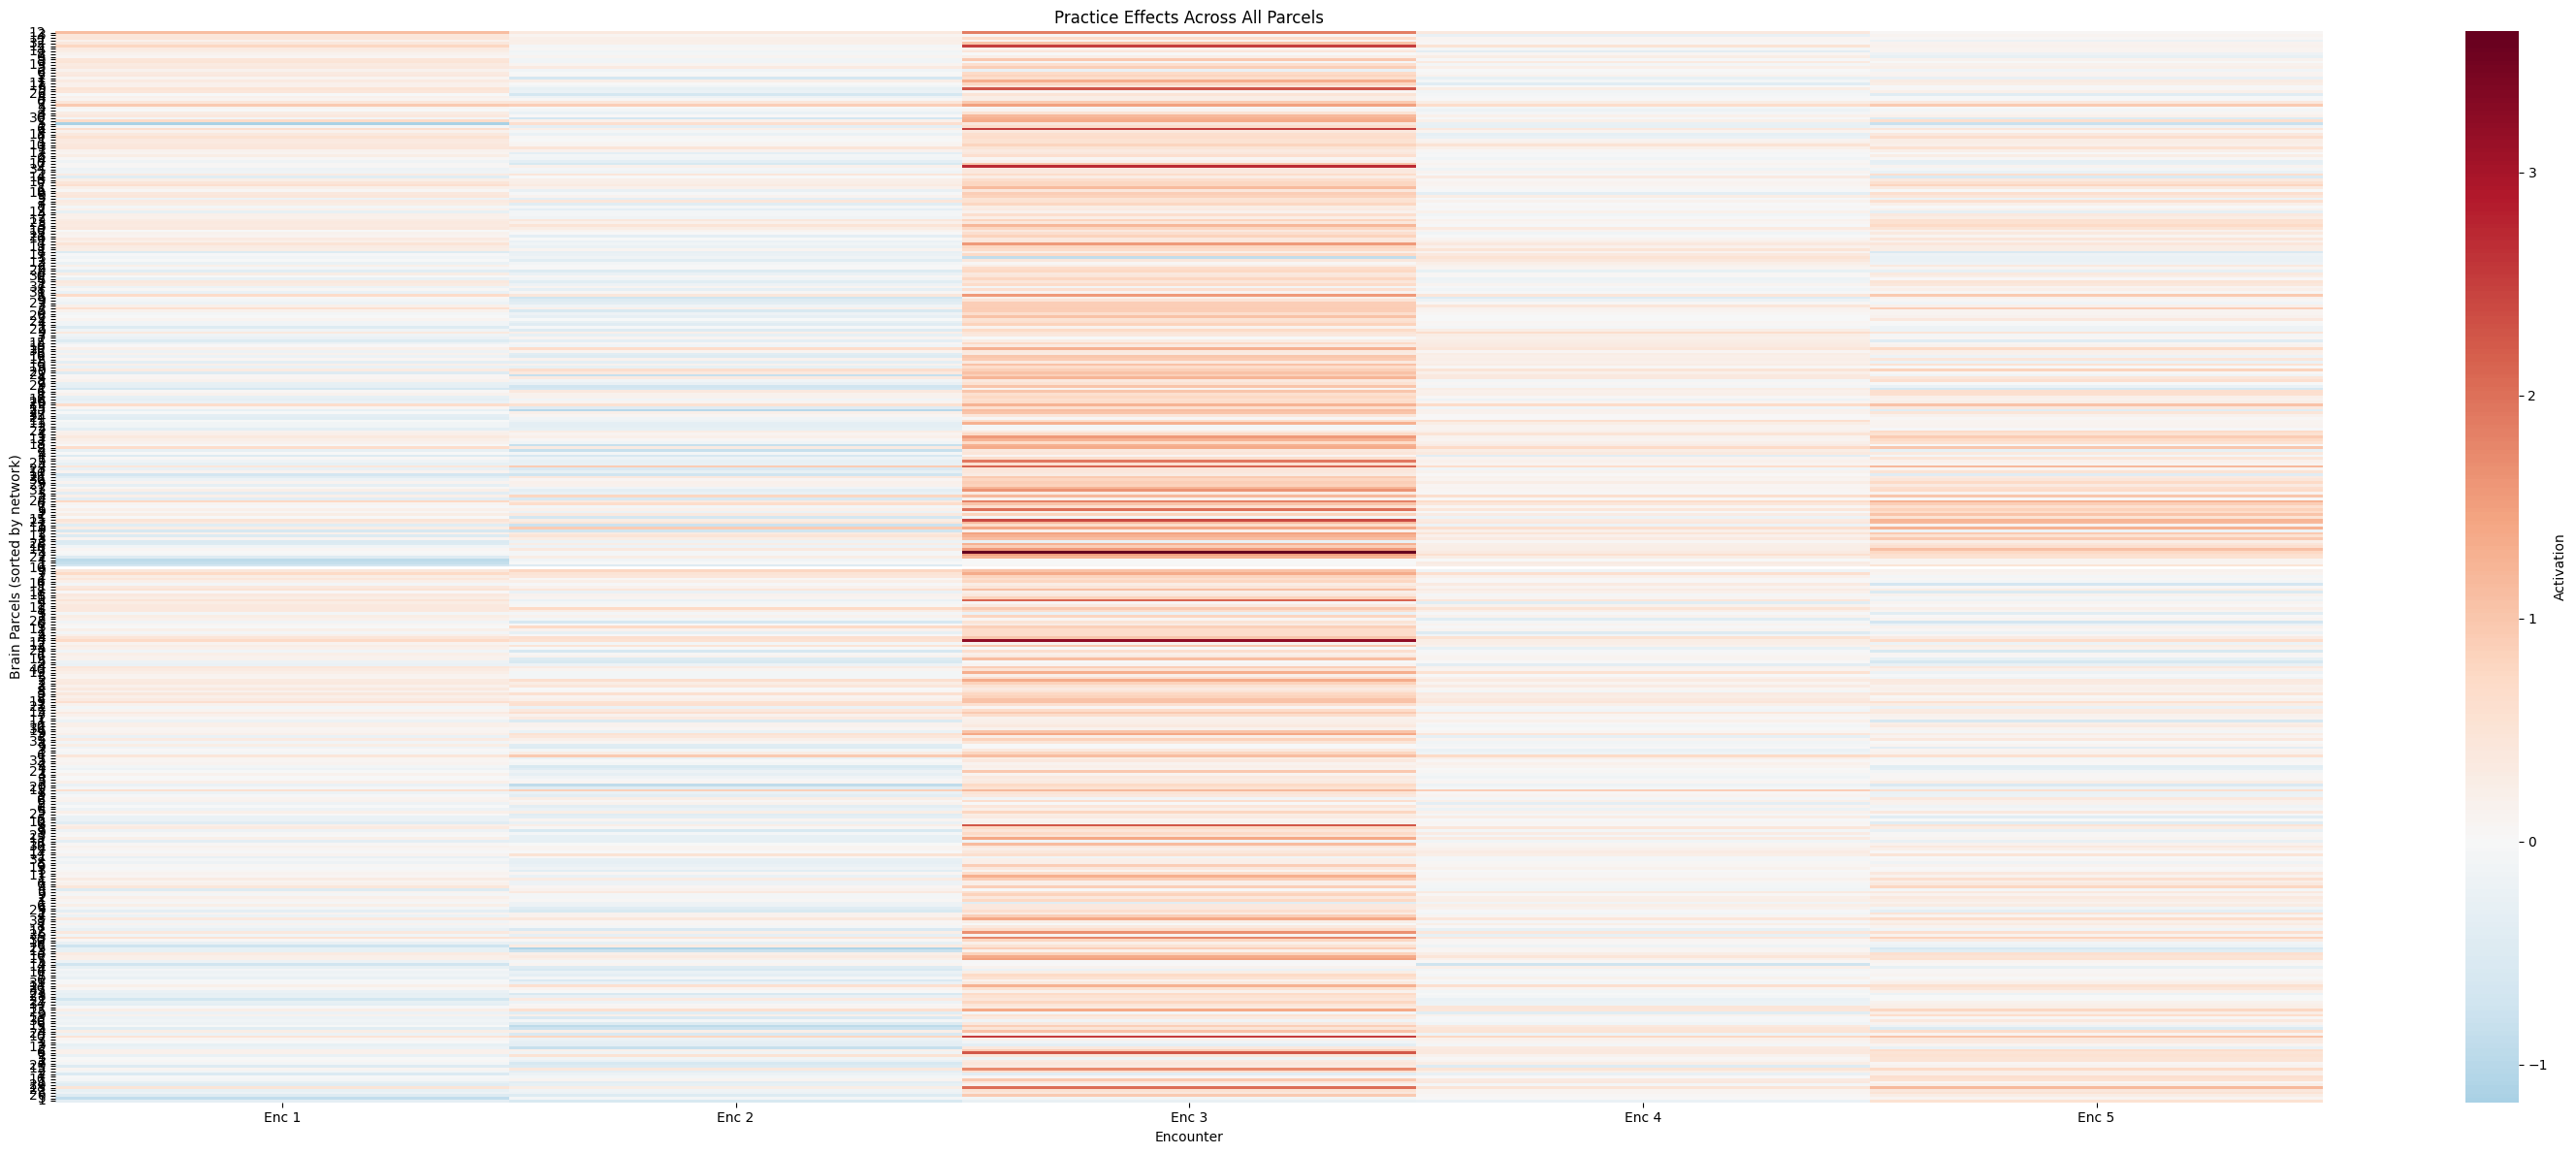

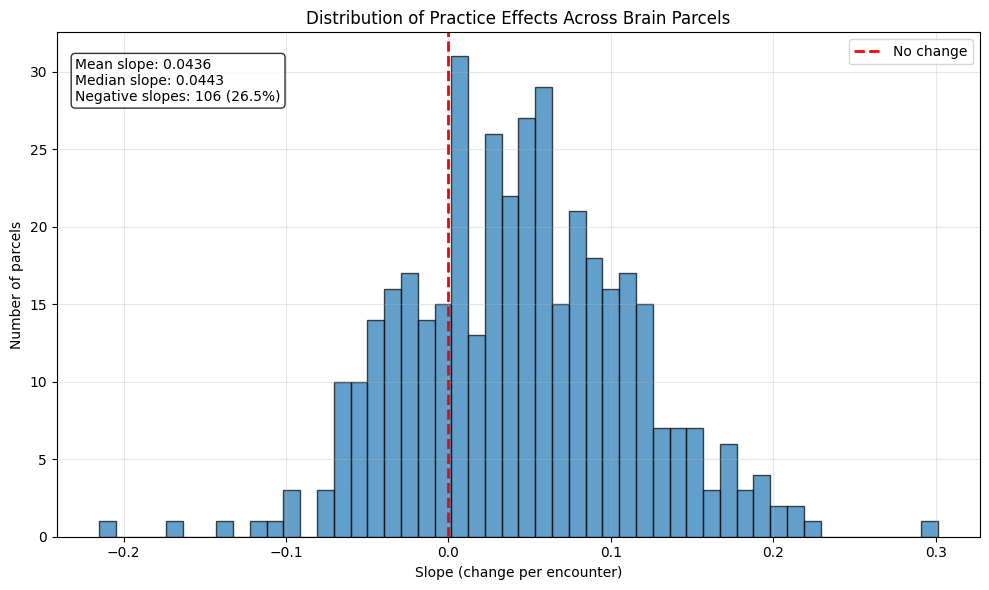

Total parcels: 400
Negative slopes (practice): 106 (26.5%)
Positive slopes (fatigue): 294 (73.5%)
Mean slope: 0.043641


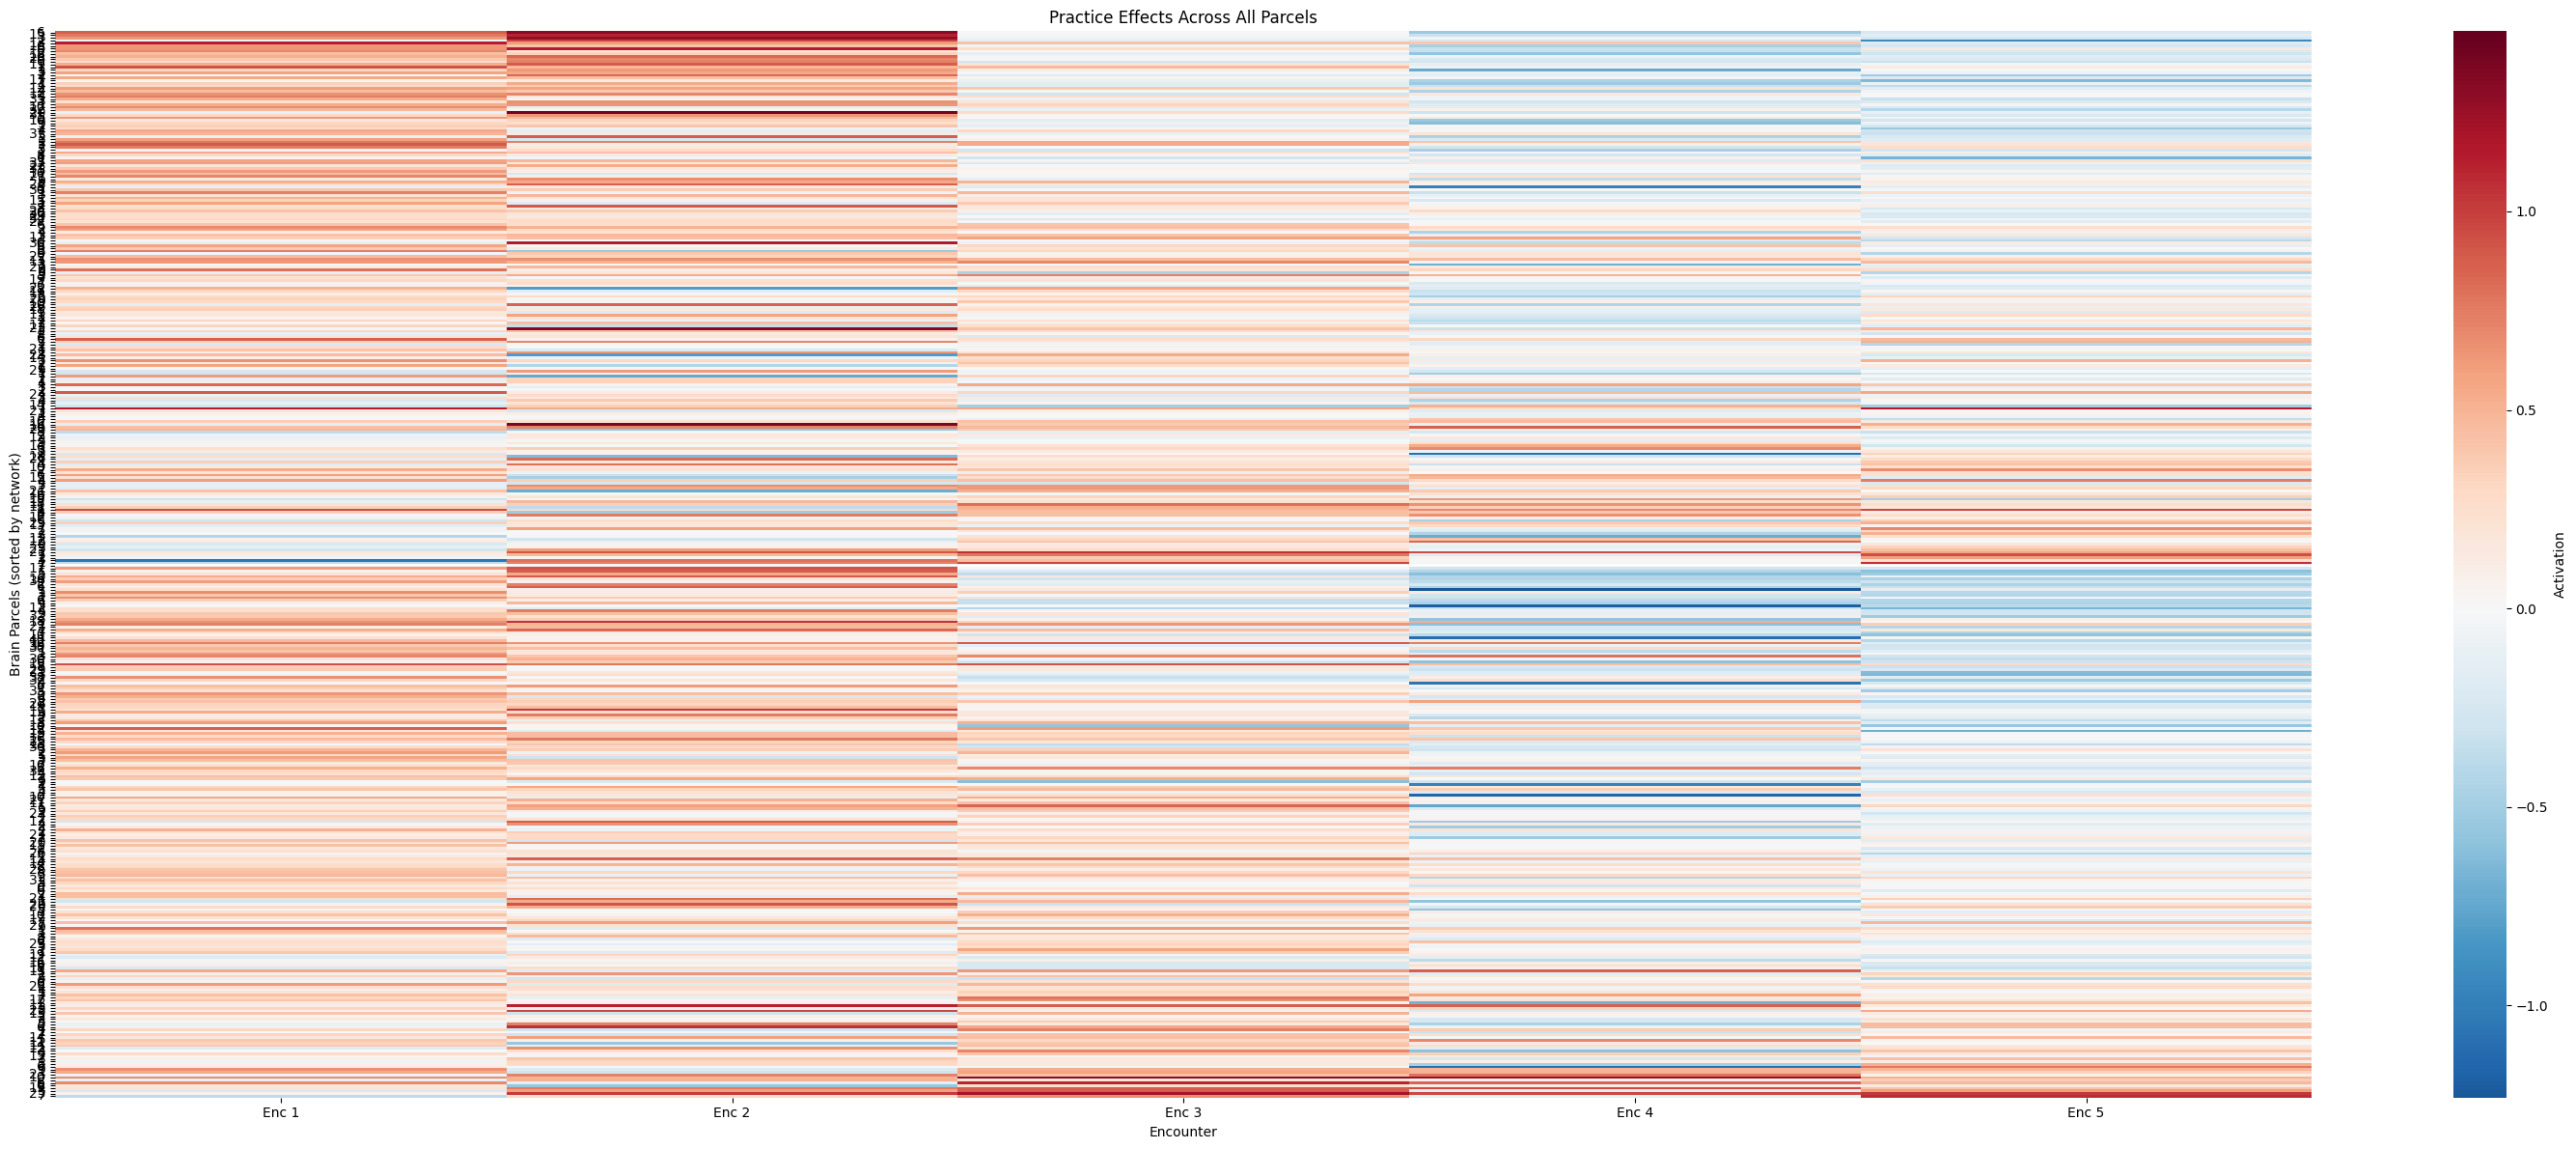

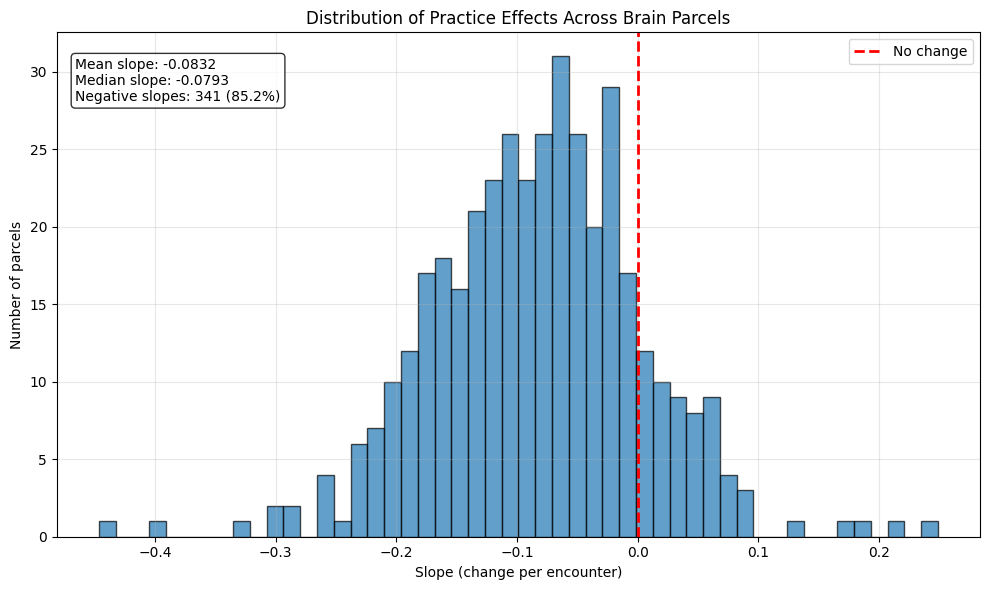

Total parcels: 400
Negative slopes (practice): 341 (85.2%)
Positive slopes (fatigue): 59 (14.8%)
Mean slope: -0.083228


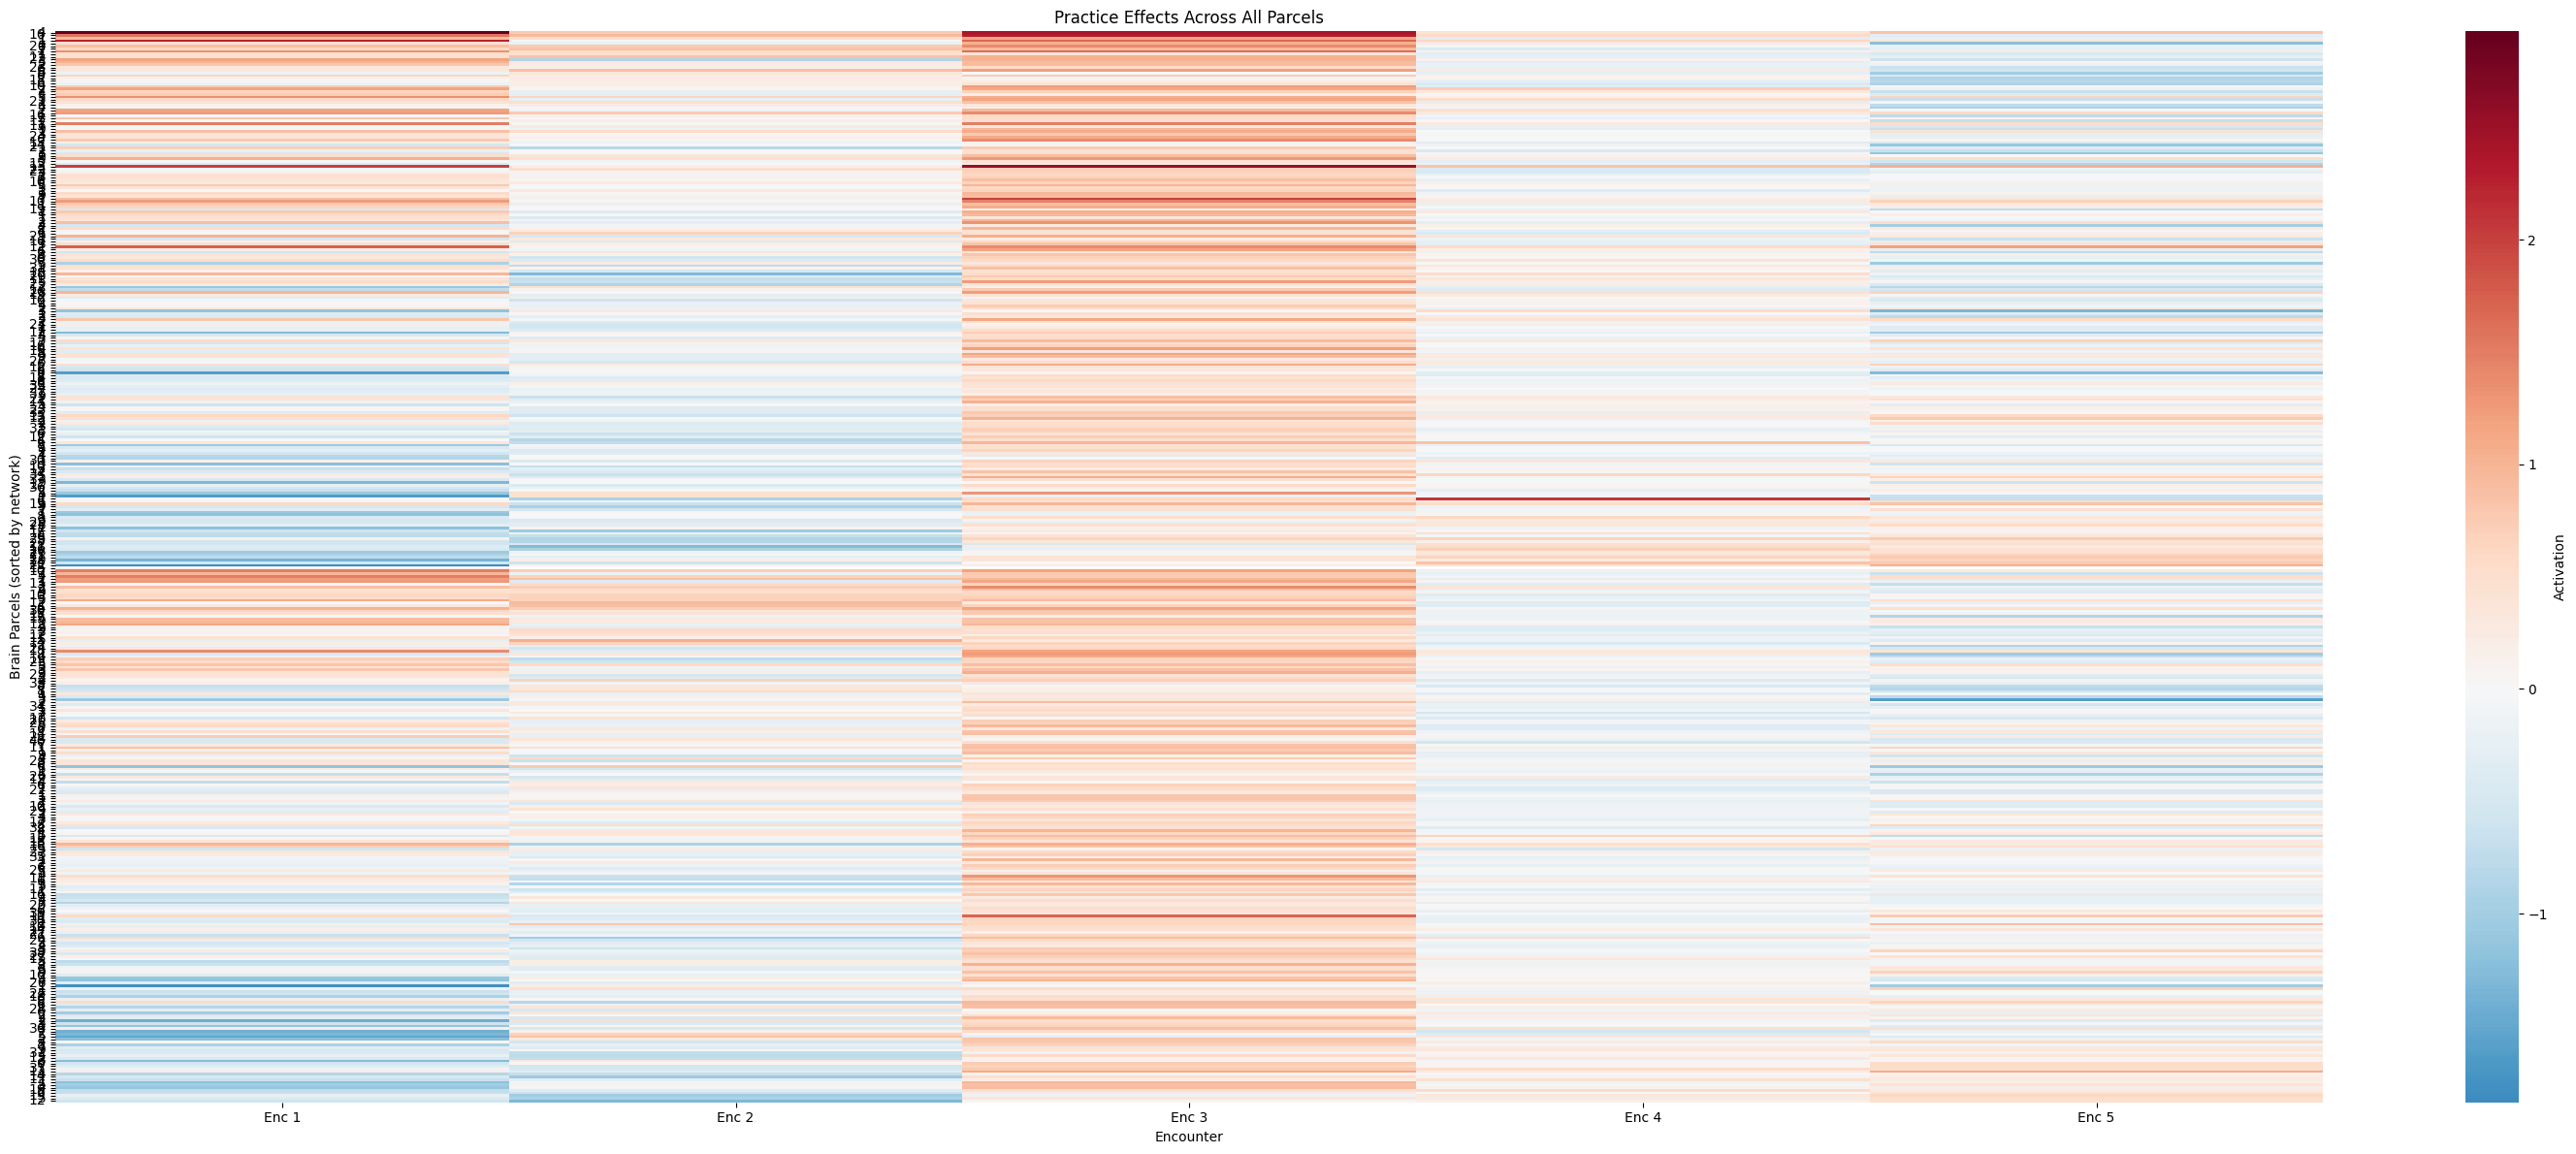

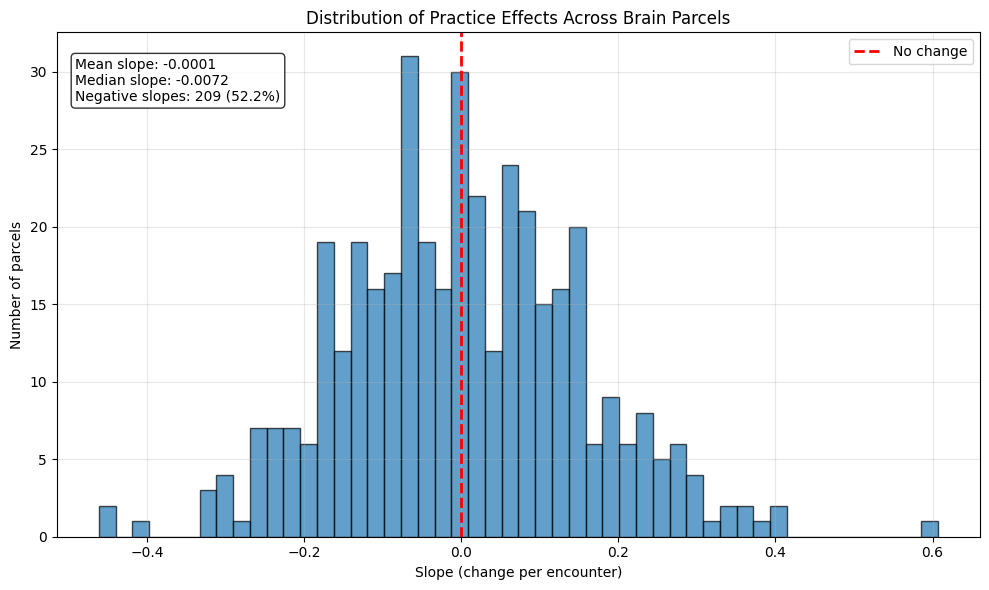

Total parcels: 400
Negative slopes (practice): 209 (52.2%)
Positive slopes (fatigue): 191 (47.8%)
Mean slope: -0.000080


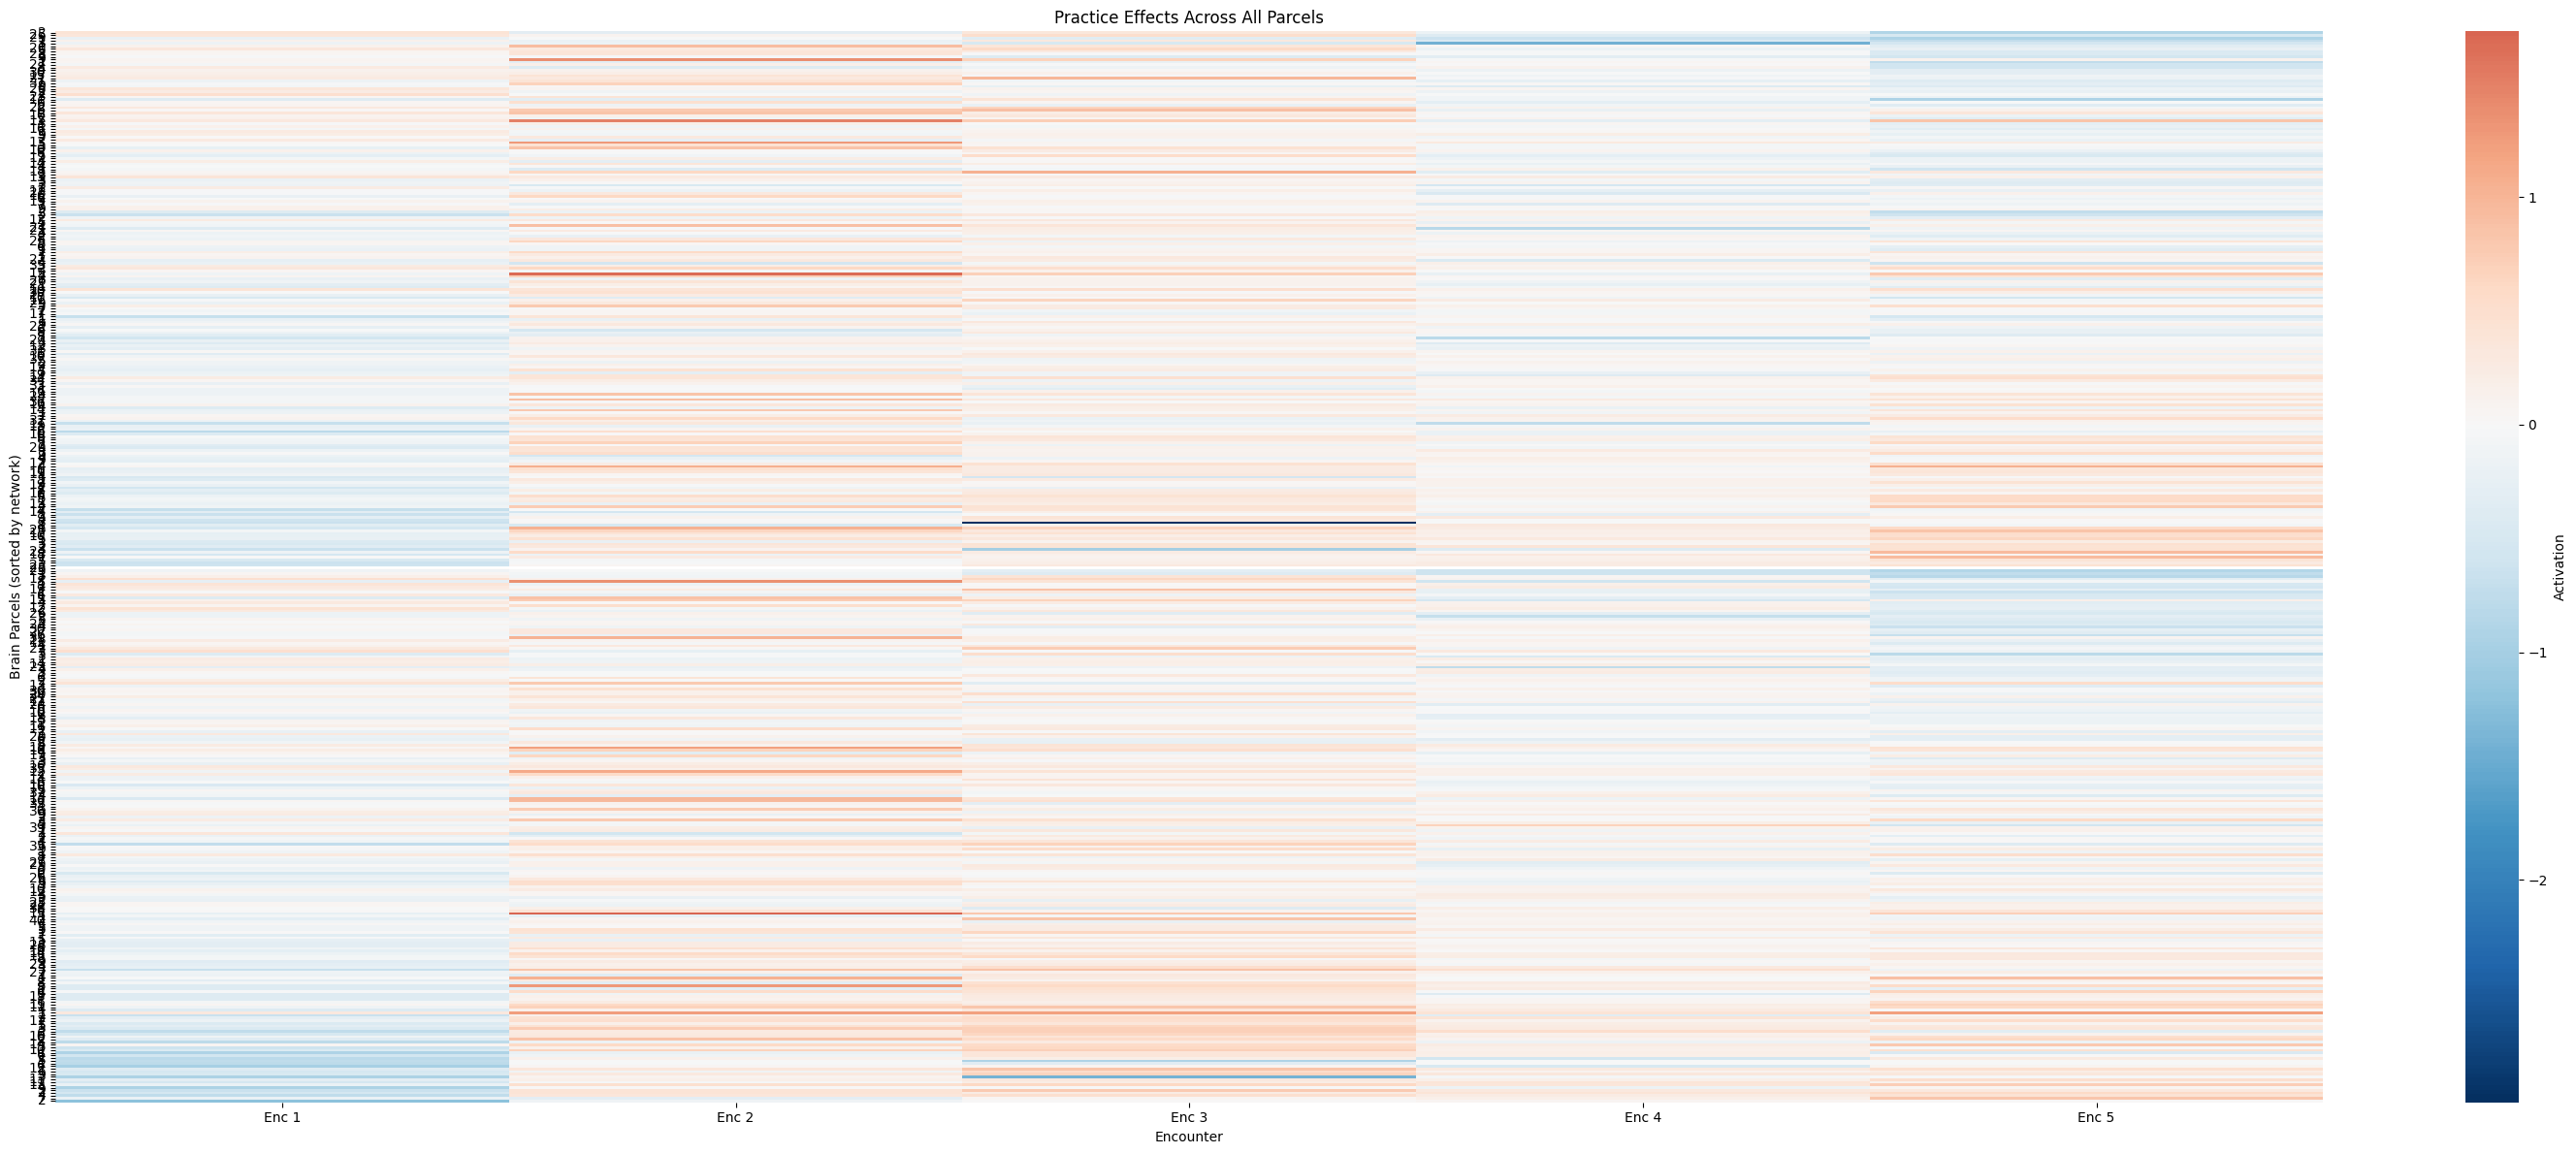

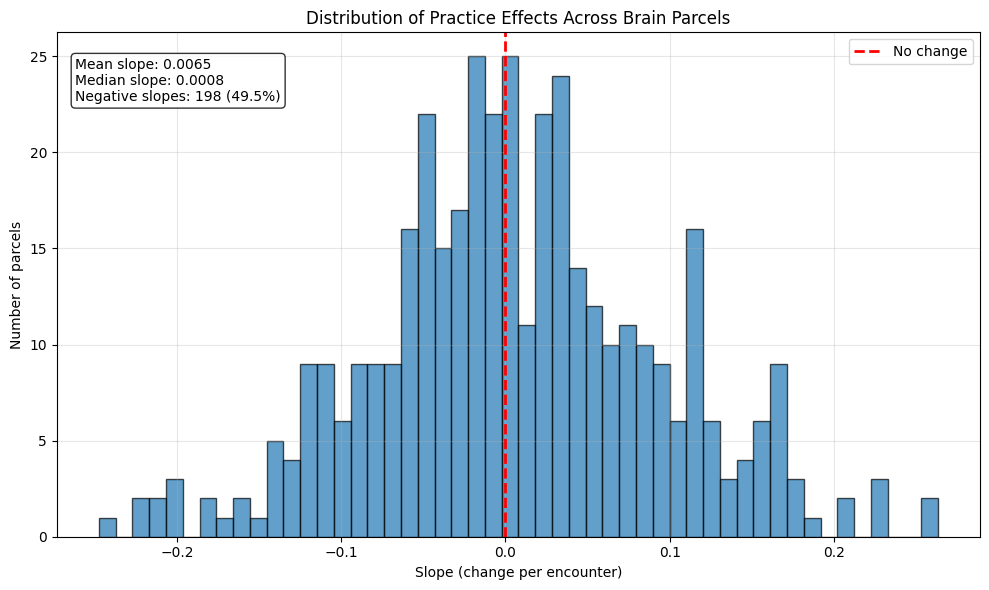

Total parcels: 400
Negative slopes (practice): 198 (49.5%)
Positive slopes (fatigue): 202 (50.5%)
Mean slope: 0.006493


In [53]:
for subject in SUBJECTS:
    if (subject == "sub-s03"):
        continue
    # Run the analysis
    task = 'nBack'
    contrast = 'twoBack-oneBack'
    
    # 1. Analyze all parcels
    parcel_results = analyze_parcel_practice_effects(loaded_parcel_dict, subject, task, contrast)
    
    # 2. Create visualizations
    create_parcel_practice_heatmap(parcel_results)
    plot_slope_hist(parcel_results)

# start with 1 subj (OLD)

In [30]:
curr_subj = 'sub-s10'
curr_task = 'nBack'
curr_contrast = "twoBack-oneBack"

encounters = ['01', '02','03','04','05']

In [31]:
parcel_dict = {curr_subj: {curr_task: {curr_contrast: {}}}}

for enc in encounters:
    # load the data
    fmri_img = task_contrast_enc_all_maps[curr_task][curr_contrast][curr_subj][enc]

    print(f"fMRI data loaded successfully for encounter {enc}")
    print(f"fMRI shape: {fmri_img.shape}")

    # make the masker and get regional avg activation
    masker = NiftiLabelsMasker(
        labels_img=schaefer_atlas.maps,
        standardize=False, 
        memory='nilearn_cache',
        strategy='mean'  # Average activation within each region
    )
    # Extract regional values
    regional_values = masker.fit_transform(fmri_img)
    # Create a more meaningful output
    region_labels = [label.decode('utf-8') if isinstance(label, bytes) else label 
                    for label in schaefer_atlas.labels]
    activation_df = pd.DataFrame({
        'region': region_labels,
        'activation': regional_values.flatten(),
        'network': [label.split('_')[1] if '7Networks' in label else 'Unknown' 
                   for label in region_labels]
    })

    # save the activation df
    parcel_dict[curr_subj][curr_task][curr_contrast][enc] = activation_df

fMRI data loaded successfully for encounter 01
fMRI shape: (97, 115, 97)
fMRI data loaded successfully for encounter 02
fMRI shape: (97, 115, 97)
fMRI data loaded successfully for encounter 03
fMRI shape: (97, 115, 97)
fMRI data loaded successfully for encounter 04
fMRI shape: (97, 115, 97)
fMRI data loaded successfully for encounter 05
fMRI shape: (97, 115, 97)


In [32]:
# attempting to analyze

def combine_sessions_data(parcel_dict, subject, task, contrast):
    """
    Combine all sessions into one DataFrame for analysis
    """
    all_sessions = []
    
    for session, activation_df in parcel_dict[subject][task][contrast].items():
        # Add session info to each dataframe
        session_df = activation_df.copy()
        session_df['session'] = session
        session_df['subject'] = subject
        session_df['task'] = task
        session_df['contrast'] = contrast
        all_sessions.append(session_df)
    
    # Combine all sessions
    combined_df = pd.concat(all_sessions, ignore_index=True)
    return combined_df

# Create combined dataset
combined_sessions = combine_sessions_data(parcel_dict, curr_subj, curr_task, curr_contrast)
print(f"Combined data shape: {combined_sessions.shape}")
print(f"Sessions: {sorted(combined_sessions['session'].unique())}")
print(f"Total regions: {len(combined_sessions['region'].unique())}")

# Look at the first few rows
print("\nFirst few rows:")
print(combined_sessions.head())

Combined data shape: (2000, 7)
Sessions: ['01', '02', '03', '04', '05']
Total regions: 400

First few rows:
               region  activation network session  subject   task  \
0  7Networks_LH_Vis_1    0.037511      LH      01  sub-s10  nBack   
1  7Networks_LH_Vis_2   -0.058325      LH      01  sub-s10  nBack   
2  7Networks_LH_Vis_3   -0.022163      LH      01  sub-s10  nBack   
3  7Networks_LH_Vis_4   -0.104559      LH      01  sub-s10  nBack   
4  7Networks_LH_Vis_5   -0.151186      LH      01  sub-s10  nBack   

          contrast  
0  twoBack-oneBack  
1  twoBack-oneBack  
2  twoBack-oneBack  
3  twoBack-oneBack  
4  twoBack-oneBack  


In [33]:
# Create wide format: regions as rows, sessions as columns
session_pivot = combined_sessions.pivot(
    index=['region', 'network'], 
    columns='session', 
    values='activation'
).reset_index()

print("Session comparison table (first 10 regions):")
print(session_pivot.head(10))

# Quick correlation between sessions
session_corr = session_pivot.set_index(['region', 'network']).corr()
print(f"\nInter-session correlations:")
print(session_corr.round(3))

Session comparison table (first 10 regions):
session                    region network        01        02        03  \
0        7Networks_LH_Cont_Cing_1      LH  0.158339  0.156434  0.324848   
1        7Networks_LH_Cont_Cing_2      LH -0.031843 -0.096951  0.610930   
2         7Networks_LH_Cont_OFC_1      LH -0.499301 -0.027256  0.129045   
3        7Networks_LH_Cont_PFCl_1      LH  0.203445  0.188177  1.151777   
4        7Networks_LH_Cont_PFCl_2      LH  0.397858  0.044123  0.807954   
5        7Networks_LH_Cont_PFCl_3      LH  0.213069 -0.134597  0.896762   
6        7Networks_LH_Cont_PFCl_4      LH  0.235823 -0.074630  0.610331   
7        7Networks_LH_Cont_PFCl_5      LH  0.372217  0.341498  0.890937   
8        7Networks_LH_Cont_PFCl_6      LH  0.455163  0.460209  0.932229   
9        7Networks_LH_Cont_PFCl_7      LH  0.966071  0.888638  1.492252   

session        04        05  
0        0.054437  0.234128  
1        0.081521  0.579964  
2       -0.062482 -0.158942  
3        

In [34]:
def analyze_session_changes(combined_df):
    """
    Comprehensive analysis of how activation changes across sessions
    """
    
    # 1. Overall session statistics
    print("="*60)
    print("SESSION-BY-SESSION ANALYSIS")
    print("="*60)
    
    session_stats = combined_df.groupby('session')['activation'].agg([
        'count', 'mean', 'std', 'min', 'max'
    ]).round(4)
    
    print("\nOverall activation by session:")
    print(session_stats)
    
    # 2. Network-level changes across sessions
    print(f"\nNetwork activation across sessions:")
    network_session = combined_df.groupby(['network', 'session'])['activation'].mean().unstack()
    print(network_session.round(4))
    
    # 3. Calculate session-to-session changes
    sessions = sorted(combined_df['session'].unique())
    wide_data = combined_df.pivot(index='region', columns='session', values='activation')
    
    print(f"\nSession-to-session changes (mean absolute difference):")
    for i in range(1, len(sessions)):
        prev_session = sessions[i-1]
        curr_session = sessions[i]
        
        change = (wide_data[curr_session] - wide_data[prev_session]).abs().mean()
        print(f"Session {prev_session} → {curr_session}: {change:.4f}")
    
    # 4. Most stable and variable regions
    region_variability = wide_data.std(axis=1).sort_values()
    
    print(f"\n10 Most STABLE regions (lowest variability):")
    for region in region_variability.head(10).index:
        network = combined_df[combined_df['region'] == region]['network'].iloc[0]
        std_val = region_variability[region]
        mean_val = wide_data.loc[region].mean()
        print(f"{std_val:.4f} | {network:8s} | {mean_val:6.3f} | {region}")
    
    print(f"\n10 Most VARIABLE regions (highest variability):")
    for region in region_variability.tail(10).index:
        network = combined_df[combined_df['region'] == region]['network'].iloc[0]
        std_val = region_variability[region]
        mean_val = wide_data.loc[region].mean()
        print(f"{std_val:.4f} | {network:8s} | {mean_val:6.3f} | {region}")
    
    return wide_data, region_variability

# Run the analysis
wide_data, region_variability = analyze_session_changes(combined_sessions)

SESSION-BY-SESSION ANALYSIS

Overall activation by session:
         count    mean     std     min     max
session                                       
01         400  0.0521  0.3129 -1.1700  1.1378
02         400 -0.0390  0.3639 -1.1321  0.9673
03         400  0.6517  0.5664 -0.8799  3.6333
04         400  0.1152  0.2356 -0.7468  0.8906
05         400  0.1932  0.3644 -0.8066  1.2860

Network activation across sessions:
session      01      02      03      04      05
network                                        
LH       0.0646 -0.0485  0.7294  0.1353  0.2544
RH       0.0396 -0.0295  0.5739  0.0952  0.1319

Session-to-session changes (mean absolute difference):
Session 01 → 02: 0.2807
Session 02 → 03: 0.7104
Session 03 → 04: 0.5707
Session 04 → 05: 0.2939

10 Most STABLE regions (lowest variability):
0.0592 | RH       |  0.086 | 7Networks_RH_SomMot_36
0.0625 | LH       |  0.006 | 7Networks_LH_Limbic_TempPole_4
0.0725 | RH       |  0.171 | 7Networks_RH_DorsAttn_Post_4
0.0910 | RH   

/tmp/ipykernel_4366/3451955874.py:99: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax7.legend()


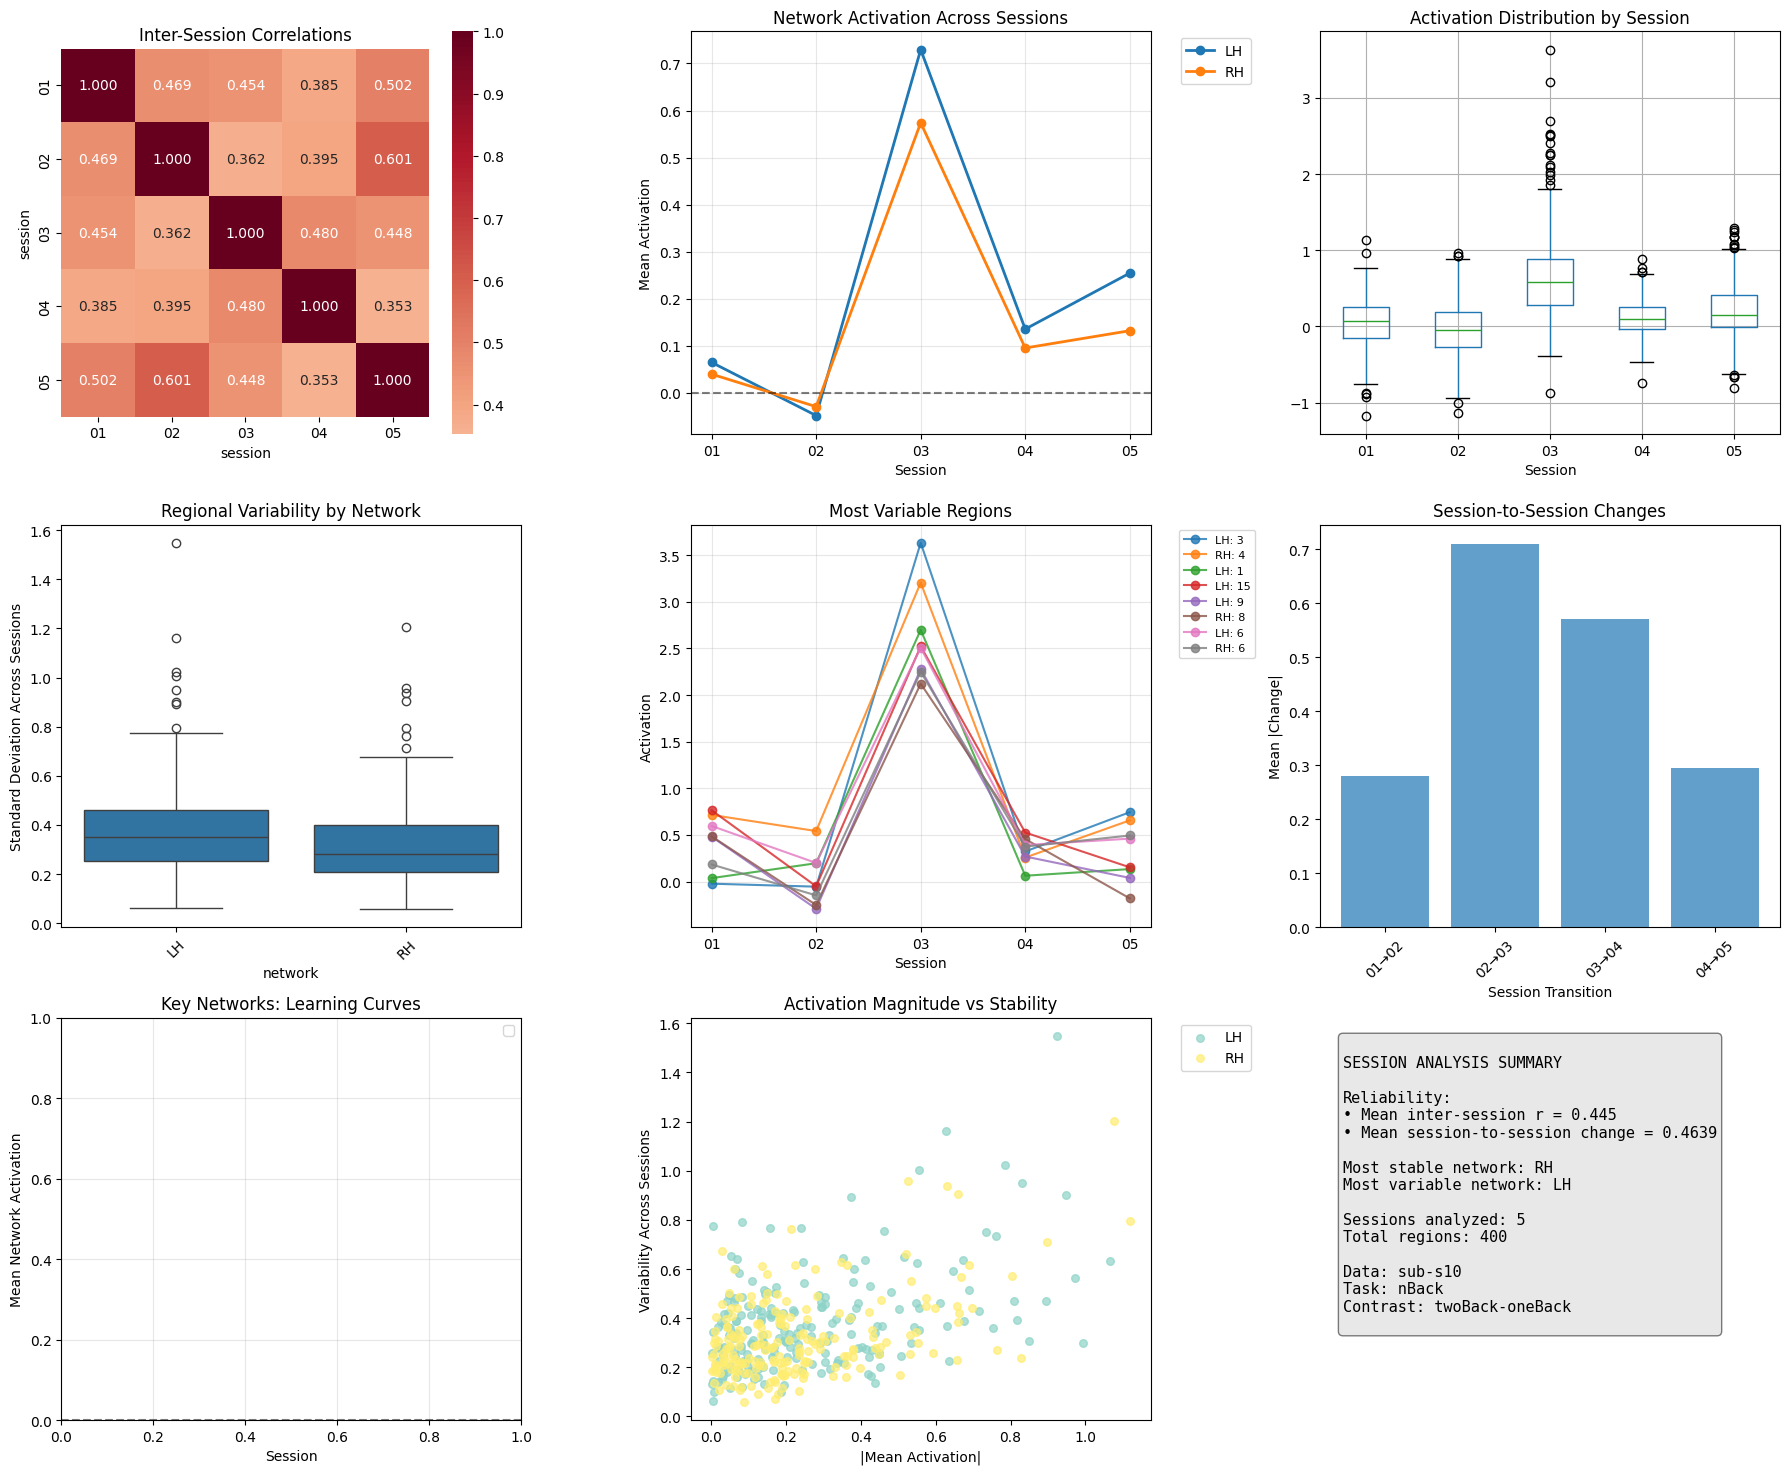

In [35]:
def create_session_visualizations(combined_df, wide_data):
    """
    Create comprehensive visualizations of session effects
    """
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    
    # 1. Session correlations heatmap
    ax1 = axes[0, 0]
    session_corr = wide_data.corr()
    sns.heatmap(session_corr, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.3f', ax=ax1)
    ax1.set_title('Inter-Session Correlations')
    
    # 2. Network activation trajectories
    ax2 = axes[0, 1]
    network_means = combined_df.groupby(['network', 'session'])['activation'].mean().reset_index()
    
    for network in network_means['network'].unique():
        if network != 'Unknown':
            net_data = network_means[network_means['network'] == network]
            ax2.plot(net_data['session'], net_data['activation'], 'o-', 
                    label=network, linewidth=2, markersize=6)
    
    ax2.set_xlabel('Session')
    ax2.set_ylabel('Mean Activation')
    ax2.set_title('Network Activation Across Sessions')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    # 3. Distribution of activations by session
    ax3 = axes[0, 2]
    combined_df.boxplot(column='activation', by='session', ax=ax3)
    ax3.set_title('Activation Distribution by Session')
    ax3.set_xlabel('Session')
    plt.suptitle('')  # Remove default title
    
    # 4. Variability by network
    ax4 = axes[1, 0]
    variability_df = pd.DataFrame({
        'region': wide_data.index,
        'variability': wide_data.std(axis=1),
        'network': [combined_df[combined_df['region'] == r]['network'].iloc[0] 
                   for r in wide_data.index]
    })
    
    sns.boxplot(data=variability_df, x='network', y='variability', ax=ax4)
    ax4.set_title('Regional Variability by Network')
    ax4.tick_params(axis='x', rotation=45)
    ax4.set_ylabel('Standard Deviation Across Sessions')
    
    # 5. Most variable regions trajectory
    ax5 = axes[1, 1]
    most_variable = wide_data.std(axis=1).nlargest(8).index
    
    for region in most_variable:
        region_data = wide_data.loc[region]
        network = combined_df[combined_df['region'] == region]['network'].iloc[0]
        ax5.plot(region_data.index, region_data.values, 'o-', 
                alpha=0.8, label=f"{network}: {region.split('_')[-1]}")
    
    ax5.set_xlabel('Session')
    ax5.set_ylabel('Activation')
    ax5.set_title('Most Variable Regions')
    ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax5.grid(True, alpha=0.3)
    
    # 6. Session-to-session changes
    ax6 = axes[1, 2]
    sessions = sorted(wide_data.columns)
    changes = []
    
    for i in range(1, len(sessions)):
        change = (wide_data.iloc[:, i] - wide_data.iloc[:, i-1]).abs().mean()
        changes.append(change)
    
    ax6.bar(range(len(changes)), changes, alpha=0.7)
    ax6.set_xlabel('Session Transition')
    ax6.set_ylabel('Mean |Change|')
    ax6.set_title('Session-to-Session Changes')
    ax6.set_xticks(range(len(changes)))
    ax6.set_xticklabels([f'{sessions[i]}→{sessions[i+1]}' for i in range(len(changes))], 
                        rotation=45)
    
    # 7. Learning curves for key networks
    ax7 = axes[2, 0]
    key_networks = ['Cont', 'Default', 'DorsAttn', 'SalVentAttn']  # Key for nBack
    
    for network in key_networks:
        if network in combined_df['network'].values:
            net_data = combined_df[combined_df['network'] == network].groupby('session')['activation'].mean()
            ax7.plot(net_data.index, net_data.values, 'o-', 
                    linewidth=3, markersize=8, label=network)
    
    ax7.set_xlabel('Session')
    ax7.set_ylabel('Mean Network Activation')
    ax7.set_title('Key Networks: Learning Curves')
    ax7.legend()
    ax7.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax7.grid(True, alpha=0.3)
    
    # 8. Reliability vs magnitude
    ax8 = axes[2, 1]
    mean_activation = wide_data.mean(axis=1)
    variability = wide_data.std(axis=1)
    
    # Color by network
    network_colors = {}
    unique_networks = variability_df['network'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_networks)))
    for i, net in enumerate(unique_networks):
        network_colors[net] = colors[i]
    
    for network in unique_networks:
        if network != 'Unknown':
            mask = variability_df['network'] == network
            ax8.scatter(np.abs(mean_activation[mask]), variability[mask], 
                       c=[network_colors[network]], label=network, alpha=0.7, s=30)
    
    ax8.set_xlabel('|Mean Activation|')
    ax8.set_ylabel('Variability Across Sessions')
    ax8.set_title('Activation Magnitude vs Stability')
    ax8.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 9. Summary statistics
    ax9 = axes[2, 2]
    ax9.axis('off')
    
    # Calculate summary stats
    mean_corr = session_corr.values[np.triu_indices_from(session_corr.values, k=1)].mean()
    overall_change = np.mean(changes) if changes else 0
    most_stable_net = variability_df.groupby('network')['variability'].mean().idxmin()
    most_variable_net = variability_df.groupby('network')['variability'].mean().idxmax()
    
    summary_text = f"""
SESSION ANALYSIS SUMMARY

Reliability:
• Mean inter-session r = {mean_corr:.3f}
• Mean session-to-session change = {overall_change:.4f}

Most stable network: {most_stable_net}
Most variable network: {most_variable_net}

Sessions analyzed: {len(sessions)}
Total regions: {len(wide_data)}

Data: {curr_subj}
Task: {curr_task}
Contrast: {curr_contrast}
    """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Create the visualizations
create_session_visualizations(combined_sessions, wide_data)